<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Visión por Computadora I - TP 2

Implementar la función `create_gauss_filter (h, w, k_size, sigma)` para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro a una imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper **"Image Sharpness Measure for Blurred Images in Frequency Domain”** comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper **“Analysis of focus measure operators in shape from focus”**.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import requests

In [2]:
def create_gauss_filter(h,w,k_size,_sigma):
    # Primero obtenemos el kernel-1D y lo multiplicamos por su traspuesto para obtener el kernel-2D
    kernel_1d = cv.getGaussianKernel(ksize=k_size, sigma=_sigma) 
    kernel_2d = kernel_1d * kernel_1d.T

    # Luego, obtenemos el filtro haciendo el padding del kernel para igualar el tamaño de la imagen original
    gaussian_filter = np.zeros((h,w), dtype=np.float32)
    origin_x = int((h - k_size) / 2)
    origin_y = int((w - k_size) / 2)
    gaussian_filter[origin_x:origin_x+k_size, origin_y:origin_y+k_size] += kernel_2d

    # Finalmente, devolvemos el filtro y su transformada de fourier, tomando el modulo y descartando la parte imaginaria
    fourier_gaussian_filter =  abs(np.fft.fft2(gaussian_filter))
    return gaussian_filter, fourier_gaussian_filter

In [6]:
# Función para descargar la imagen que vamos a utilizar de prueba
def descargar_imagen(url):
    response = requests.get(url)
    if response.status_code == 200:
        image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        image = cv.imdecode(image_array, cv.IMREAD_COLOR)
        return image
    else:
        raise Exception(f"Falla descarga. Codigo: {response.status_code}")

#### 1. Graficamos ambas representaciones

In [3]:
gf, fgf = create_gauss_filter(200,400,6,1.5)

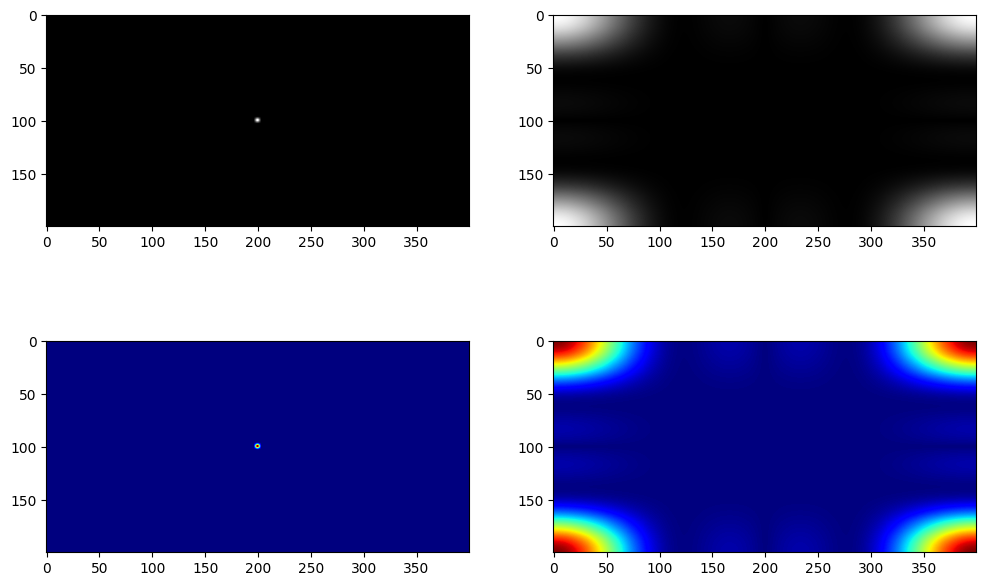

In [4]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(gf, cmap='gray')
plt.subplot(3,2,2)
plt.imshow(fgf, cmap='gray')

plt.subplot(3,2,3)
plt.imshow(gf, cmap='jet')
plt.subplot(3,2,4)
plt.imshow(fgf, cmap='jet')

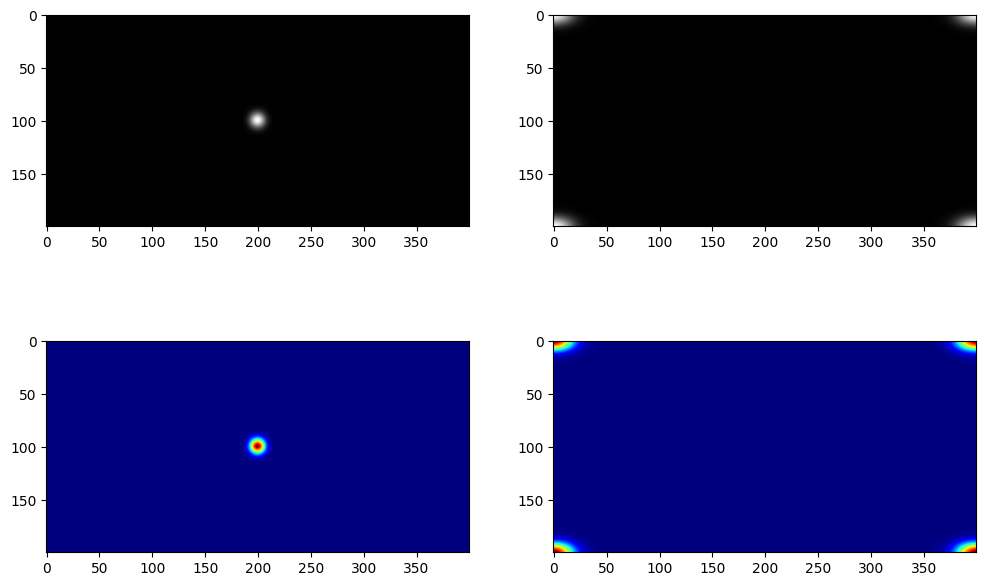

In [9]:
# Probamos con otros valores de kernel y sigma
gf, fgf = create_gauss_filter(200,400,28,5)

plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(gf, cmap='gray')
plt.subplot(3,2,2)
plt.imshow(fgf, cmap='gray')

plt.subplot(3,2,3)
plt.imshow(gf, cmap='jet')
plt.subplot(3,2,4)
plt.imshow(fgf, cmap='jet')

##### Vamos a aplicar el filtro a una imagen para validar su funcionamiento en los dominios espacial y espectral

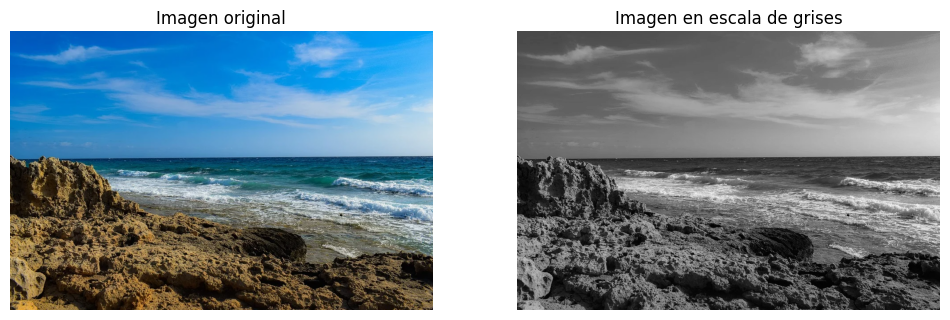

In [7]:
# Comenzamos descargando la imagen de prueba, que es aquella que tiene la playa, el mar y el cielo
url1 = 'https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/vision_computadora_I/raw/11-cohorte/Material_TPs/TP1/segmentacion.png'

img = descargar_imagen(url1)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

M = img.shape[0]
N = img.shape[1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap='gray')
plt.title('Imagen original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(gray,cmap='gray')
plt.title('Imagen en escala de grises')
plt.axis('off')
plt.show()

(-0.5, 952.5, 627.5, -0.5)

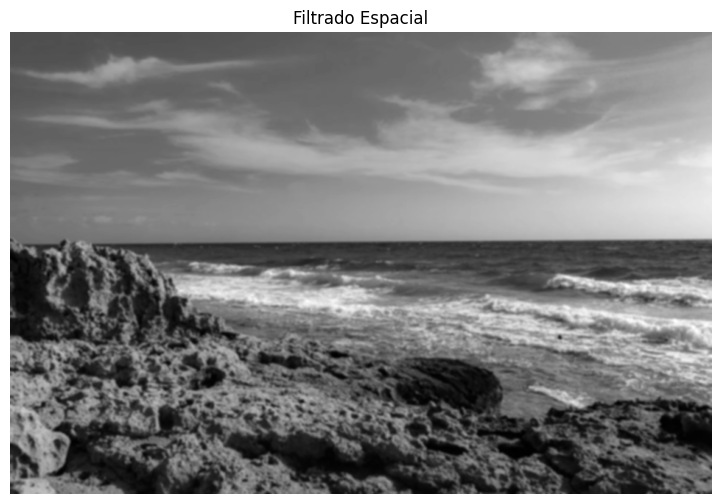

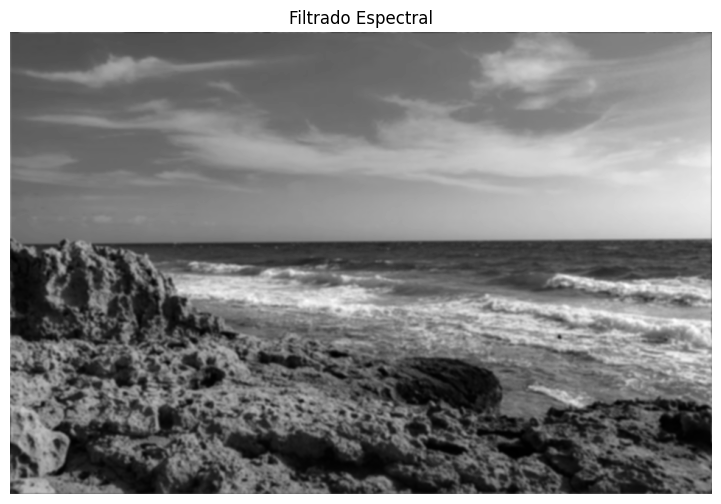

In [13]:
# Aplicamos los filtros
iW, iH = gray.shape[::-1]

gf, fgf = create_gauss_filter(iH,iW,6,1.5)

# Filtrado espacial
filtrado_espacial = cv.filter2D(gray, -1, gf)
plt.figure(figsize=(12, 6))
plt.imshow(filtrado_espacial,cmap='gray')
plt.title('Filtrado Espacial')
plt.axis('off')

# Filtardo espectral
shifted_img_fft = np.fft.fftshift(np.fft.fft2(gray))
filtrado_spectral = shifted_img_fft *  np.fft.fftshift(fgf)
f_ishift = np.fft.ifftshift(filtrado_spectral)
fil_spec_esp = np.real(np.fft.ifft2(f_ishift))
fil_int = np.uint8(fil_spec_esp)
plt.figure(figsize=(12, 6))
plt.imshow(fil_spec_esp,cmap='gray')
plt.title('Filtrado Espectral')
plt.axis('off')

#### 2. Comparamos los filtrados espectral y espacial usando uno de los métodos descriptos en el apéndice del paper **“Analysis of focus measure operators in shape from focus”**.

In [14]:
# Calculo de la image quality measure (FM) de acuerdo al paper Image Sharpness Measure for Blurred Images in Frequency Domain
# para la imagen original

def FM(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    modf = (np.abs(fshift))
    Mf = np.max(modf)
    mf = np.min(modf)

    count = np.sum(modf > (Mf/1000))
    print(f"La cantidad de pixels que superan el valor Mf/1000 es {count}")
    M = image.shape[0]
    N = image.shape[1]
    FM = count/(N*M)
    return FM

Fesp = FM(filtrado_espacial)
Fspec = FM(fil_int)

print(f"Operador de la medida de foco elegido:  Gaussian Derivative (GRA1) A10 para el filtro espacial es:  VALOR: {Fesp:.4f} ")
print(f"Operador de la medida de foco elegido:  Gaussian Derivative (GRA1) A10 para el filtro espectral es:  VALOR: {Fspec:.4f} ")

La cantidad de pixels que superan el valor Mf/1000 es 6451
La cantidad de pixels que superan el valor Mf/1000 es 6373
Operador de la medida de foco elegido:  Gaussian Derivative (GRA1) A10 para el fil espacial es:  VALOR: 0.0108 
Operador de la medida de foco elegido:  Gaussian Derivative (GRA1) A10 para el fil espectral es:  VALOR: 0.0106 


Como vemos, los resultados luego de aplicar los dos filtrados son muy similares

#### 3. Utilizamos el método descripto en el paper **"Image Sharpness Measure for Blurred Images in Frequency Domain”** para comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [15]:
# Funcion para derivar parcialmente el kernel gausisano
def derv_gauss(sigma):

    size= int(5 * sigma)
    if size % 2 == 0: # lo hago impar
        size += 1

    # creo un mesh grid
    k = size // 2
    x, y= np.mgrid[-k:k+1, -k:k+1]

    # derivada en x  teorica de la gaussiana en la malla
    gx= -x * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gx /= np.sum(np.abs(gx))  # factor de normalizacion asi suma uno la suma de los coeficientes

    # en y
    gy = -y * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gy /= np.sum(np.abs(gy))

    return gx, gy

In [16]:
def GRA1(image,s1):
# calcula la ecuacion A15 
    gx, gy = derv_gauss(s1)
    t1 = cv.filter2D(image, -1, gx)
    t2 = cv.filter2D(image, -1, gy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(t1,cmap='gray')
    plt.title('Convolucion entre la imagen y Gx')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(t2,cmap='gray')
    plt.title('Convolucion entre la imagen y Gy')
    plt.axis('off')
    plt.show()
    F = (1/(N*M))*np.sum(t1**2 + t2**2)
    return F

uint8


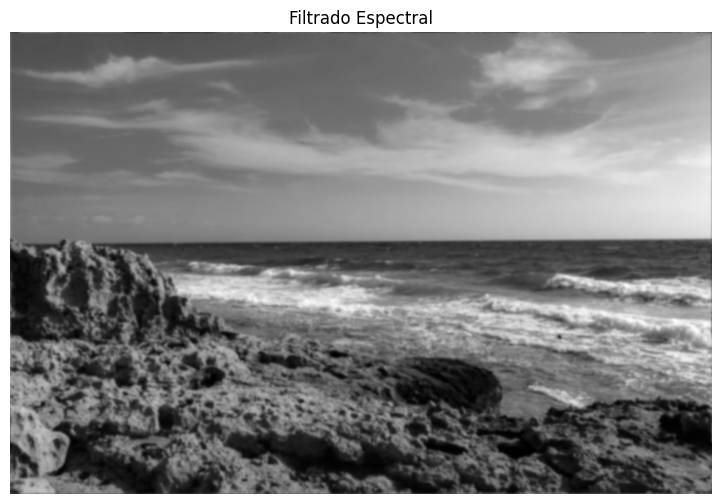

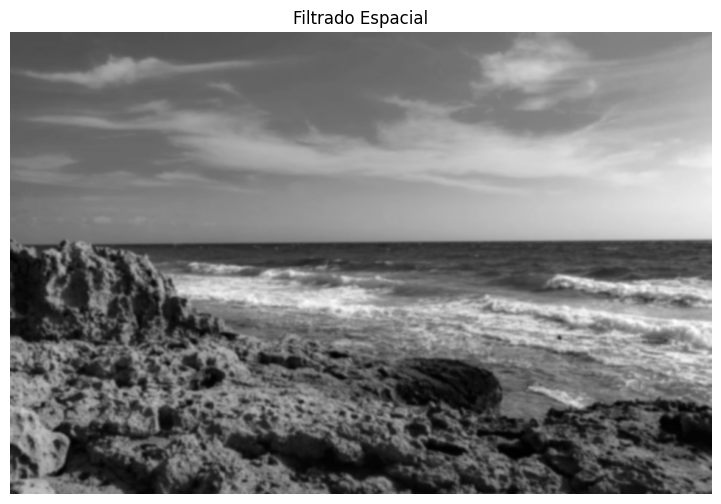

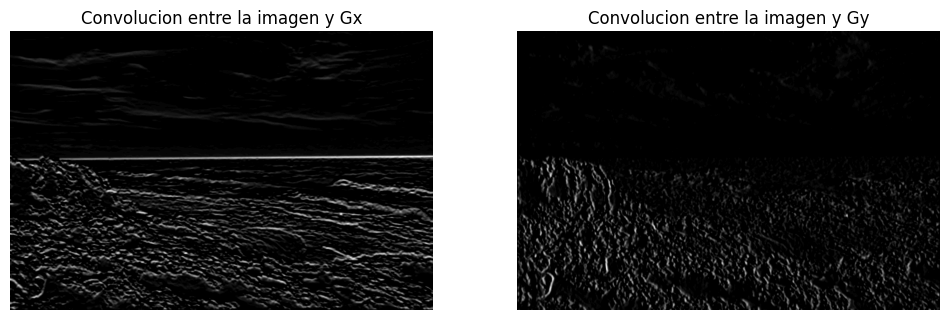

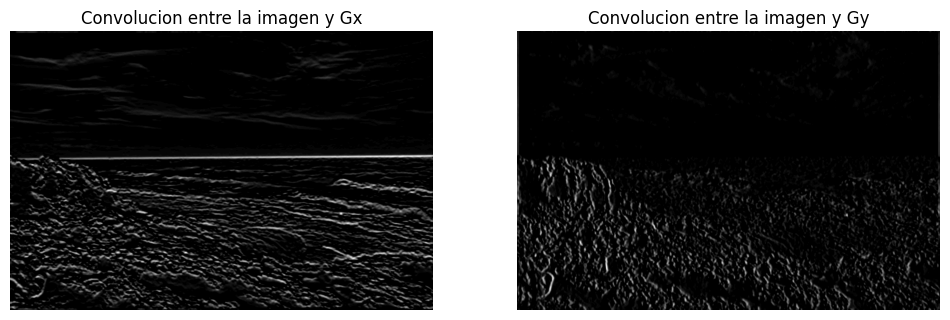

Operador de la medida de foco elegido:  Gaussian Derivative (GRA1) A10 para el fil espacial es:  VALOR: 20.234 
Operador de la medida de foco elegido:  Gaussian Derivative (GRA1) A10 para el fil espectral es:  VALOR: 20.633 


In [17]:
gf, fgf = create_gauss_filter(M,N,13,1.5)
s1 = 1.0 # Sigma del operador de foco

# Filtardo espectral
shifted_img_fft = np.fft.fftshift(np.fft.fft2(gray))
filtrado_spectral = shifted_img_fft *  np.fft.fftshift(fgf)
f_ishift = np.fft.ifftshift(filtrado_spectral)
fil_spec_esp = np.real(np.fft.ifft2(f_ishift))
fil_int = np.uint8(fil_spec_esp)
print(fil_int.dtype)
plt.figure(figsize=(12, 6))
plt.imshow(fil_spec_esp,cmap='gray')
plt.title('Filtrado Espectral')
plt.axis('off')

# Filtrado espacial 
filtrado_espacial = cv.filter2D(gray, -1, gf)
plt.figure(figsize=(12, 6))
plt.imshow(filtrado_espacial,cmap='gray')
plt.title('Filtrado Espacial')
plt.axis('off')

Fesp = GRA1(filtrado_espacial,s1)
Fspec = GRA1(fil_int,s1)

print(f"Operador de la medida de foco elegido:  Gaussian Derivative (GRA1) A10 para el fil espacial es:  VALOR: {Fesp:.3f} ")
print(f"Operador de la medida de foco elegido:  Gaussian Derivative (GRA1) A10 para el fil espectral es:  VALOR: {Fspec:.3f} ")

Como se puede apreciar a través de las diferentes medidas de foco utilizadas, tanto el filtrado espectral como el filtrado espacial arrojan resultados casi iguales. 